In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

# Load and Prepare Data

In [3]:
red_train_x = pd.read_csv('red_train_x.csv')
white_train_x = pd.read_csv('white_train_x.csv')
red_train_y = pd.read_csv('red_train_y.csv')
white_train_y = pd.read_csv('white_train_y.csv')
red_test_x = pd.read_csv('red_test_x.csv')
white_test_x = pd.read_csv('white_test_x.csv')
red_test_y = pd.read_csv('red_test_y.csv')
white_test_y = pd.read_csv('white_test_y.csv')
combined_train_x = pd.read_csv("combined_train_x")
combined_train_y = pd.read_csv("combined_train_y")
combined_test_x = pd.read_csv("combined_test_x")
combined_test_y = pd.read_csv("combined_test_y")

# Create Base XGBoost Models

## Red Model

In [183]:
red_model = xgb.XGBRegressor().fit(red_train_x, red_train_y)
mae = mean_absolute_error(red_test_y, np.around(red_model.predict(red_test_x)))
rmse = np.sqrt(mean_squared_error(red_test_y, np.around(red_model.predict(red_test_x))))
print('RMSE for red base model: ', rmse)
print('MAE for red base model: ', mae)

RMSE for red base model:  0.7053367989832943
MAE for red base model:  0.4225


## White Model

In [184]:
white_model = xgb.XGBRegressor().fit(white_train_x, white_train_y)
mae = mean_absolute_error(white_test_y, np.around(white_model.predict(white_test_x)))
rmse = np.sqrt(mean_squared_error(white_test_y, np.around(white_model.predict(white_test_x))))
print('RMSE for white base model: ', rmse)
print('MAE for white base model: ', mae)

RMSE for white base model:  0.6737043498600912
MAE for white base model:  0.37551020408163266


## Combined Model

In [185]:
combined_model = xgb.XGBRegressor().fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_test_y, np.around(combined_model.predict(combined_test_x)))
rmse = np.sqrt(mean_squared_error(combined_test_y, np.around(combined_model.predict(combined_test_x))))
print('RMSE for combined base model: ', rmse)
print('MAE for combined base model: ', mae)

RMSE for combined base model:  0.689704507519204
MAE for combined base model:  0.3944615384615385


# Tuning Models

## Red Model

In [149]:
start_time = time.time()
param_grid = {'max_depth': [4, 6, 8],
              'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.5, 0.75, 1],
              'colsample_bytree': [0.5, 0.75, 1.0],
              'reg_lambda':[0, 1, 10],
              'gamma': [0, 10, 100]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid,
                                 n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result = grid_search.fit(red_train_x, red_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best: 0.578070 using {'subsample': 1, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}
Time taken =  1.7860136349995932  minutes


In [150]:
start_time = time.time()
param_grid = {'max_depth': [8, 9, 10, 11, 12],
              'n_estimators': [1000, 1500, 2000],
              'learning_rate': [0.05],
              'subsample': [0.8, 0.9, 1],
              'colsample_bytree': [0.3, 0.4, 0.5],
              'reg_lambda':[0, 0.25, 0.5],
              'gamma': [0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result = grid_search.fit(red_train_x, red_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best: 0.574486 using {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 1500, 'reg_lambda': 0.5, 'subsample': 0.9}
Time taken =  4.21326855023702  minutes


In [190]:
#manual tune max_depth, subsample, and colsample_bytree
red_model_tuned_rmse = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.05, max_depth = 11, n_estimators = 1500,
                                  reg_lambda = 0.5, subsample = 1, colsample_bytree = 0.6).fit(red_train_x, red_train_y)
mae = mean_absolute_error(red_test_y, np.around(red_model_tuned_rmse.predict(red_test_x)))
rmse = np.sqrt(mean_squared_error(red_test_y, np.around(red_model_tuned_rmse.predict(red_test_x))))
print("RMSE for red tuned model: ", rmse)
print('MAE for red tuned model: ', mae)

RMSE for red tuned model:  0.6442049363362563
MAE for red tuned model:  0.345


## White Model

In [105]:
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.5, 0.75, 1],
              'colsample_bytree': [0.5, 0.75, 1],
              'reg_lambda':[0, 1, 10],
              'gamma': [0, 10, 100]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid,
                                 n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result = grid_search.fit(white_train_x, white_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best: 0.635257 using {'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}
Time taken =  3.8692580978075664  minutes


In [106]:
start_time = time.time()
param_grid = {'max_depth': [8, 10, 12, 14],
              'n_estimators': [1000, 2000, 3000],
              'learning_rate': [0.001, 0.01],
              'subsample': [0.75],
              'colsample_bytree': [0.5],
              'reg_lambda':[0, 0.2, 0.4, 0.6, 0.8],
              'gamma': [0]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result = grid_search.fit(white_train_x, white_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 2 folds for each of 120 candidates, totalling 240 fits


/Users/keatonolds/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.651685 using {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 14, 'n_estimators': 1000, 'reg_lambda': 0.6, 'subsample': 0.75}
Time taken =  3.6731221675872803  minutes


In [107]:
start_time = time.time()
param_grid = {'max_depth': [13, 14, 15, 16],
              'n_estimators': [500, 1000, 1500],
              'learning_rate': [0.01],
              'subsample': [0.75],
              'colsample_bytree': [0.5],
              'reg_lambda':[0.6],
              'gamma': [0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result = grid_search.fit(white_train_x, white_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best: 0.625868 using {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 16, 'n_estimators': 1000, 'reg_lambda': 0.6, 'subsample': 0.75}
Time taken =  1.2273271163304647  minutes


In [180]:
#manual tuning of max_depth, colsample, and learning_rate
white_model_tuned = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.02, max_depth = 9, n_estimators = 1000,
                                  reg_lambda = 0.6, subsample = 0.75, colsample_bytree = 0.6).fit(white_train_x, white_train_y)
mae = mean_absolute_error(white_test_y, np.around(white_model_tuned.predict(white_test_x)))
rmse = np.sqrt(mean_squared_error(white_test_y, np.around(white_model_tuned.predict(white_test_x))))

print('RMSE for white tuned model: ', rmse)
print('MAE for white tuned model: ', mae)

RMSE for white tuned model:  0.6279217421667403
MAE for white tuned model:  0.33877551020408164


## Combined Model

In [247]:
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.5, 0.75, 1],
              'colsample_bytree': [0.5, 0.75, 1],
              'reg_lambda':[0, 1, 10],
              'gamma': [0, 10, 100]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid,
                                 n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result_coarse = grid_search.fit(combined_train_x, combined_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result_coarse.best_score_), grid_result_coarse.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best: 0.624159 using {'subsample': 1, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}
Time taken =  5.504720747470856  minutes


In [248]:
cv_results_coarse = pd.DataFrame(grid_result_coarse.cv_results_)
cv_results_coarse.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.334797,0.009614,0.014031,0.004505,0.5,1,100,4,0.05,10,0.75,"{'subsample': 0.5, 'reg_lambda': 1, 'n_estimat...",-0.491454,-0.505492,-0.500274,-0.513091,-0.535161,-0.509094,0.014815,116
1,4.377103,0.052363,0.036476,0.005284,0.75,10,500,8,0.05,0,1,"{'subsample': 0.75, 'reg_lambda': 10, 'n_estim...",-0.399148,-0.373186,-0.392131,-0.405863,-0.409887,-0.396043,0.012926,6
2,5.015058,0.074045,0.014182,0.009110,1,10,1000,8,0.1,100,0.5,"{'subsample': 1, 'reg_lambda': 10, 'n_estimato...",-0.607809,-0.637592,-0.609388,-0.603710,-0.641493,-0.619998,0.016112,126
3,1.521933,0.017652,0.003518,0.001440,0.5,1,500,4,0.05,100,0.75,"{'subsample': 0.5, 'reg_lambda': 1, 'n_estimat...",-0.636521,-0.656821,-0.636604,-0.622515,-0.660190,-0.642530,0.014056,162
4,3.560316,0.048102,0.005232,0.002044,0.75,1,1000,6,0.05,100,0.5,"{'subsample': 0.75, 'reg_lambda': 1, 'n_estima...",-0.614415,-0.640304,-0.615113,-0.611478,-0.645314,-0.625325,0.014415,142


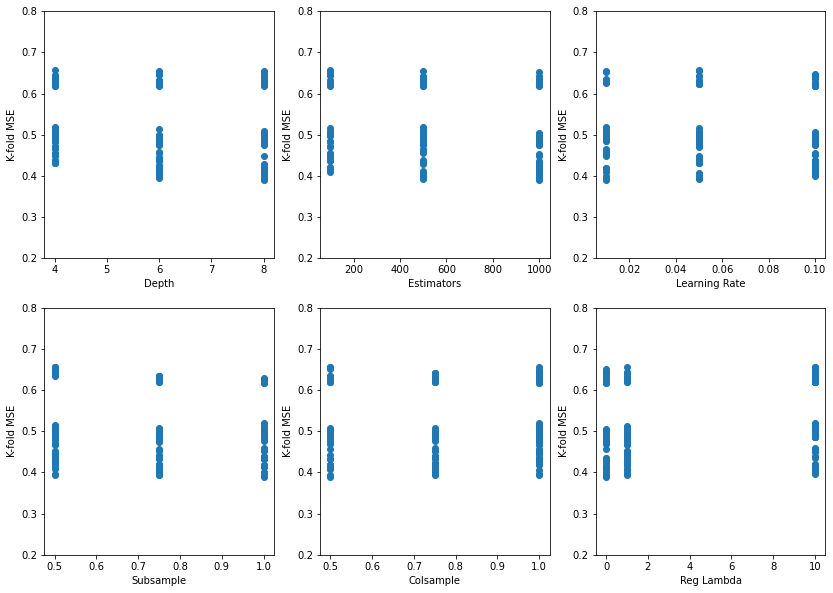

In [262]:
fig, axes = plt.subplots(2,3,figsize=(14,10))
plt.subplots_adjust(wspace=0.2)
axes[0,0].plot(cv_results_coarse.param_max_depth, -cv_results_coarse.mean_test_score, 'o')
axes[0,0].set_ylim([0.2, 0.8])
axes[0,0].set_xlabel('Depth')
axes[0,0].set_ylabel('K-fold MSE')
axes[0,1].plot(cv_results_coarse.param_n_estimators, -cv_results_coarse.mean_test_score, 'o')
axes[0,1].set_ylim([0.2, 0.8])
axes[0,1].set_xlabel('Estimators')
axes[0,1].set_ylabel('K-fold MSE')
axes[0,2].plot(cv_results_coarse.param_learning_rate, -cv_results_coarse.mean_test_score, 'o')
axes[0,2].set_ylim([0.2, 0.8])
axes[0,2].set_xlabel('Learning Rate')
axes[0,2].set_ylabel('K-fold MSE')
axes[1,0].plot(cv_results_coarse.param_subsample, -cv_results_coarse.mean_test_score, 'o')
axes[1,0].set_ylim([0.2, 0.8])
axes[1,0].set_xlabel('Subsample')
axes[1,0].set_ylabel('K-fold MSE')
axes[1,1].plot(cv_results_coarse.param_colsample_bytree, -cv_results_coarse.mean_test_score, 'o')
axes[1,1].set_ylim([0.2, 0.8])
axes[1,1].set_xlabel('Colsample')
axes[1,1].set_ylabel('K-fold MSE')
axes[1,2].plot(cv_results_coarse.param_reg_lambda, -cv_results_coarse.mean_test_score, 'o')
axes[1,2].set_ylim([0.2, 0.8])
axes[1,2].set_xlabel('Reg Lambda')
axes[1,2].set_ylabel('K-fold MSE');

Text(0, 0.5, 'K-fold MSE')

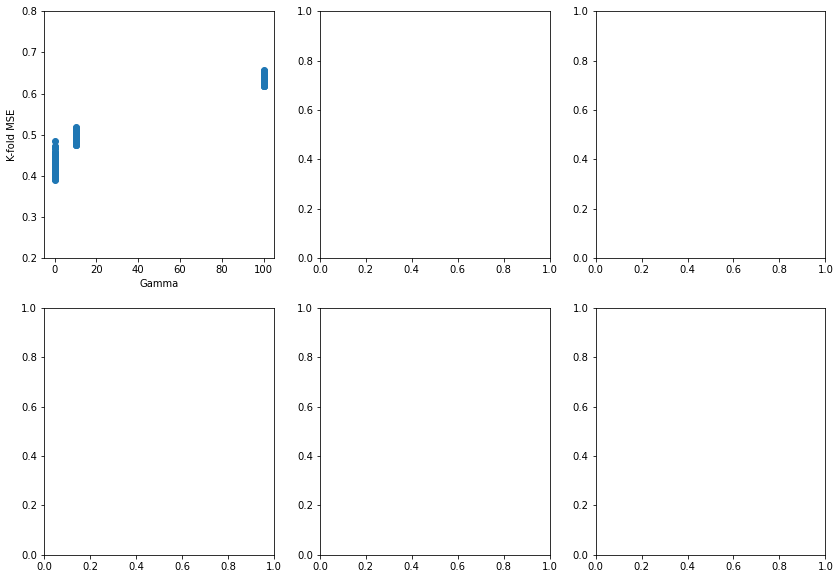

In [263]:
fig, axes = plt.subplots(2,3,figsize=(14,10))
plt.subplots_adjust(wspace=0.2)
axes[0,0].plot(cv_results_coarse.param_gamma, -cv_results_coarse.mean_test_score, 'o')
axes[0,0].set_ylim([0.2, 0.8])
axes[0,0].set_xlabel('Gamma')
axes[0,0].set_ylabel('K-fold MSE')

In [249]:
start_time = time.time()
param_grid = {'max_depth': [8,9,10,11,12],
              'n_estimators': [300, 500, 700],
              'learning_rate': [0.05],
              'subsample': [0.75],
              'colsample_bytree': [0.75],
              'reg_lambda':[2,4,6,8,10],
              'gamma': [0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result_fine = grid_search.fit(combined_train_x, combined_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result_fine.best_score_), grid_result_fine.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/Users/keatonolds/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.619580 using {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 11, 'n_estimators': 300, 'reg_lambda': 2, 'subsample': 0.75}
Time taken =  3.5876929998397826  minutes


In [250]:
cv_results_fine = pd.DataFrame(grid_result_fine.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.982388,0.033330,0.016246,0.004796,0.75,0,0.05,8,300,2,0.75,"{'colsample_bytree': 0.75, 'gamma': 0, 'learni...",-0.399407,-0.367659,-0.393171,-0.402273,-0.414168,-0.395336,0.015427,72
1,1.933444,0.042108,0.018848,0.007318,0.75,0,0.05,8,300,4,0.75,"{'colsample_bytree': 0.75, 'gamma': 0, 'learni...",-0.398254,-0.367278,-0.391557,-0.402240,-0.411171,-0.394100,0.014838,69
2,1.875898,0.018725,0.048756,0.021021,0.75,0,0.05,8,300,6,0.75,"{'colsample_bytree': 0.75, 'gamma': 0, 'learni...",-0.398886,-0.373083,-0.390820,-0.403892,-0.413608,-0.396058,0.013658,73
3,1.976302,0.062502,0.024439,0.008567,0.75,0,0.05,8,300,8,0.75,"{'colsample_bytree': 0.75, 'gamma': 0, 'learni...",-0.402882,-0.370360,-0.393368,-0.400866,-0.418027,-0.397101,0.015585,74
4,1.930929,0.076824,0.016630,0.002593,0.75,0,0.05,8,300,10,0.75,"{'colsample_bytree': 0.75, 'gamma': 0, 'learni...",-0.399795,-0.371826,-0.391245,-0.405734,-0.418479,-0.397416,0.015566,75


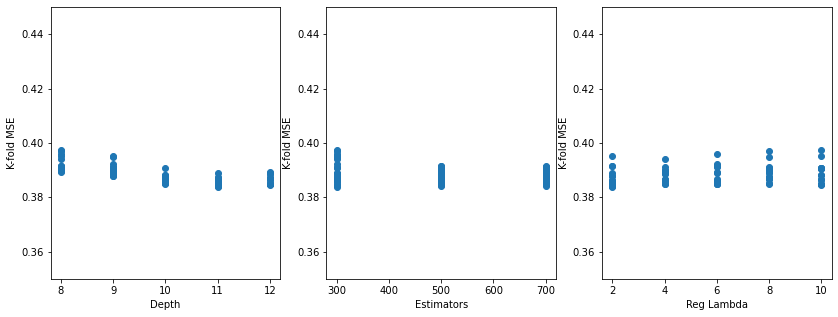

In [259]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results_fine.param_max_depth, -cv_results_fine.mean_test_score, 'o')
axes[0].set_ylim([0.35, 0.45])
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold MSE')
axes[1].plot(cv_results_fine.param_n_estimators, -cv_results_fine.mean_test_score, 'o')
axes[1].set_ylim([0.35, 0.45])
axes[1].set_xlabel('Estimators')
axes[1].set_ylabel('K-fold MSE')
axes[2].plot(cv_results_fine.param_reg_lambda, -cv_results_fine.mean_test_score, 'o')
axes[2].set_ylim([0.35, 0.45])
axes[2].set_xlabel('Reg Lambda')
axes[2].set_ylabel('K-fold MSE');

In [310]:
#manual tuning of learning_rate
combined_model_tuned = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.07, max_depth = 11, n_estimators = 300,
                                  reg_lambda = 2, subsample = 0.75, colsample_bytree = 0.75).fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_test_y, np.around(combined_model_tuned.predict(combined_test_x)))
rmse = np.sqrt(mean_squared_error(combined_test_y, np.around(combined_model_tuned.predict(combined_test_x))))

print('RMSE for combined tuned model: ', rmse)
print('MAE for combined tuned model: ', mae)

RMSE for combined tuned model:  0.6401922788086044
MAE for combined tuned model:  0.34584615384615386


In [297]:
importance = list(combined_model_tuned.feature_importances_)
pred = list(combined_model_tuned.feature_names_in_)
d = {'Predictor': pred, 'Importance': importance}
df = pd.DataFrame(data = d)
df.sort_values(by = 'Importance', ascending = False)

,Predictor,Importance
11,type_red,0.197583
10,alcohol,0.183607
12,type_white,0.153492
9,sulphates,0.061978
5,free sulfur dioxide,0.057157
6,total sulfur dioxide,0.052034
7,density,0.051388
4,chlorides,0.047413
8,pH,0.046766
3,residual sugar,0.044626


In [212]:
preds = np.around(combined_model_tuned.predict(combined_test_x)).astype(int)
preds = pd.Series(preds)
preds

0       6
1       6
2       5
3       5
4       6
       ..
1620    6
1621    5
1622    6
1623    6
1624    6
Length: 1625, dtype: int64

In [208]:
actual = combined_test_y.squeeze()
actual

0       6
1       5
2       5
3       6
4       6
       ..
1620    6
1621    5
1622    6
1623    7
1624    6
Name: quality, Length: 1625, dtype: int64

In [214]:
d = {'actual': actual, 'predicted': preds}
data = pd.DataFrame(data=d)
data

,actual,predicted
0,6,6
1,5,6
2,5,5
3,6,5
4,6,6
...,...,...
1620,6,6
1621,5,5
1622,6,6
1623,7,6


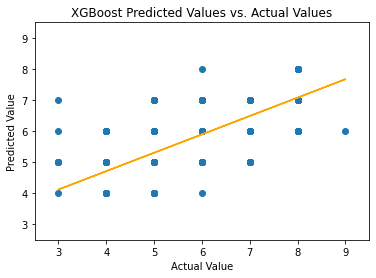

In [228]:
plt.scatter(actual, preds)
z = np.polyfit(actual, preds, 1)
p = np.poly1d(z)
plt.plot(actual, p(actual), color = 'orange')
plt.xlim(2.5, 9.5)
plt.ylim(2.5, 9.5)
plt.title('XGBoost Predicted Values vs. Actual Values')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.show()

# Try Reduce Overfitting

In [35]:
combined_model_tuned_2 = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.07, max_depth = 11, n_estimators = 300,
                                  reg_lambda = 2, subsample = 0.75, colsample_bytree = 0.75).fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_test_y, np.around(combined_model_tuned_2.predict(combined_test_x)))
rmse = np.sqrt(mean_squared_error(combined_test_y, np.around(combined_model_tuned_2.predict(combined_test_x))))

print('RMSE for combined tuned model: ', rmse)
print('MAE for combined tuned model: ', mae)

RMSE for combined tuned model:  0.6401922788086044
MAE for combined tuned model:  0.34584615384615386


In [36]:
np.sqrt(mean_squared_error(combined_train_y, np.around(combined_model_tuned_2.predict(combined_train_x))))

0.0

# Summary

## Red Wine

Base model MAE: 0.423; Base model RMSE: 0.705

Tuned model MAE: 0.345; Tuned model RMSE: 0.644

MAE Improvement: 0.078 (18.44%); RMSE Improvement: 0.061 (8.65%)

## White Wine

Base model MAE:  0.376; Base model RMSE: 0.674

Tuned model MAE: 0.339; Tuned model RMSE: 0.628

Improvement: 0.037 (9.84%); RMSE Improvement: 0.046 (6.82%)

## Combined Wines

Base model MAE: 0.394; Base model RMSE: 0.690

Tuned model MAE: 0.346; Tuned model RMSE: 0.640

Improvement: 0.048 (12.18%); RMSE Improvement: 0.05 (7.25%)

In [266]:
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.5, 0.75, 1],
              'colsample_bytree': [0.5, 0.75, 1],
              'reg_lambda':[0, 1, 10],
              'gamma': [0, 10, 100]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid,
                                 n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_absolute_error')
grid_result_coarse = grid_search.fit(combined_train_x, combined_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result_coarse.best_score_), grid_result_coarse.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best: 0.652146 using {'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}
Time taken =  7.241981931527456  minutes


In [267]:
start_time = time.time()
param_grid = {'max_depth': [8,9,10,11,12],
              'n_estimators': [1000, 1500, 2000],
              'learning_rate': [0.05],
              'subsample': [0.75],
              'colsample_bytree': [0.5],
              'reg_lambda':[0, 0.25, 0.5],
              'gamma': [0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result_fine = grid_search.fit(combined_train_x, combined_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result_fine.best_score_), grid_result_fine.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best: 0.617126 using {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 1000, 'reg_lambda': 0.5, 'subsample': 0.75}
Time taken =  3.721790067354838  minutes


In [291]:
#manual tuning of learning_rate
combined_model_tuned_mae = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.05, max_depth = 14, n_estimators = 1000,
                                  reg_lambda = 2, subsample = 0.6, colsample_bytree = 0.75).fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_test_y, np.around(combined_model_tuned_mae.predict(combined_test_x)))
rmse = np.sqrt(mean_squared_error(combined_test_y, np.around(combined_model_tuned_mae.predict(combined_test_x))))

print('RMSE for combined tuned model: ', rmse)
print('MAE for combined tuned model: ', mae)

RMSE for combined tuned model:  0.6421119001448987
MAE for combined tuned model:  0.34584615384615386


In [300]:
red_preds = pd.Series(np.around(red_model_tuned.predict(red_test_x)))
white_preds = pd.Series(np.around(white_model_tuned.predict(white_test_x)))
comb_pred = pd.concat([red_preds, white_preds])
comb_train = pd.concat([red_test_y, white_test_y])

In [305]:
rmse = np.sqrt(mean_squared_error(comb_train, comb_pred))
rmse

0.6373020054525532

In [309]:
np.sqrt(mean_squared_error(combined_train_y, np.around(combined_model_tuned.predict(combined_train_x))))

0.0